In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

import matplotlib.pyplot as plt

In [2]:
# Constants definition. Aplicar data augmentation.
batch_size = 100
epochs = 75
num_classes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creating dataloaders
# ToTensor() - Converts a Image (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
# APPLY SOME DATA AUGMENTATIONS -> HorizontalFLips + Translations + Rotations
# Para estar igual que en keras, añadiríamos zoom
train_transforms = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(p=0.0),
                                                   torchvision.transforms.RandomAffine(degrees=3, translate=(0.1, 0.1)),
                                                   torchvision.transforms.ToTensor()])

train_set = torchvision.datasets.MNIST('.data/', train=True, download=True, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

test_set = torchvision.datasets.MNIST('.data/', train=False, download=True, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

# Statistics printing
x_batch, y_batch = iter(train_loader).next()
print("Training set: {} samples - Max value: {} - Min value: {}".format(len(train_loader.dataset),
                                                                        x_batch.max(), x_batch.min()))
x_batch, y_batch = iter(test_loader).next()
print("Test set: {} samples - Max value: {} - Min value: {}".format(len(test_loader.dataset),
                                                                    x_batch.max(), x_batch.min()))
print("Example batch shape: {}".format(x_batch.shape))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw

Training set: 60000 samples - Max value: 1.0 - Min value: 0.0
Test set: 10000 samples - Max value: 1.0 - Min value: 0.0
Example batch shape: torch.Size([100, 1, 28, 28])


In [3]:
# There are no GaussianNoise Layer in Pytorch
# https://discuss.pytorch.org/t/writing-a-simple-gaussian-noise-layer-in-pytorch/4694/4
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.
    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize: this will bias the
            network to generate vectors with smaller values.
    """

    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0).to(device).float()

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).normal_() * scale
            x = x + sampled_noise
        return x

In [4]:
# Creating our Neural Network - Fully Connected
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.gn0 = GaussianNoise(0.3)
        self.linear1 = nn.Linear(784, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.gn1 = GaussianNoise(0.3)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(1024, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.gn2 = GaussianNoise(0.3)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(1024, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.gn3 = GaussianNoise(0.3)
        self.relu3 = nn.ReLU()
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        out = self.gn0(x)
        out = self.relu1(self.gn1(self.bn1(self.linear1(out))))
        out = self.relu2(self.gn2(self.bn2(self.linear2(out))))
        out = self.relu3(self.gn3(self.bn3(self.linear3(out))))
        out = self.classifier(out)
        return out

In [5]:
# Instantiating the network and printing its architecture
net = Net().to(device)
print(net)

Net(
  (gn0): GaussianNoise()
  (linear1): Linear(in_features=784, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gn1): GaussianNoise()
  (relu1): ReLU()
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (bn2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gn2): GaussianNoise()
  (relu2): ReLU()
  (linear3): Linear(in_features=1024, out_features=1024, bias=True)
  (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gn3): GaussianNoise()
  (relu3): ReLU()
  (classifier): Linear(in_features=1024, out_features=10, bias=True)
)


In [7]:
# Training hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)
# Podríamos usar Adam en lugar de SGD
#optimizer = optim.Adam(net.parameters(), lr=0.1)

In [8]:
# Learning Rate Annealing (LRA) scheduling
# lr = 0.1     if epoch < 25
# lr = 0.01    if 30 <= epoch < 50
# lr = 0.001   if epoch >= 50
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25, 50], gamma=0.1)
# alternativa para el lr scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5) # factor 0.1 de serie

In [9]:
# Crear listas para imprimir luego
train_accuracys = []
test_accuracys = []
# Start training
print("\n---- Start Training ----")
best_accuracy = -1
for epoch in range(epochs):

    # TRAIN THE NETWORK
    train_loss, train_correct = 0, 0
    net.train()
    for inputs, targets in train_loader:
        # data is a list of [inputs, labels]
        inputs, targets = inputs.to(device), targets.to(device)
        # care! net expect a 784 size vector and our dataset provide 1x28x28 (channels, height, width) -> Reshape!
        inputs = inputs.view(inputs.size(0), -1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        _, pred = outputs.max(1)  # get the index of the max log-probability
        train_correct += pred.eq(targets).sum().item()

        # print statistics
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)

    # TEST NETWORK
    net.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # care! net expect a 784 size vector and our dataset provide 1x28x28 (channels, height, width) -> Reshape!
            inputs = inputs.view(inputs.size(0), -1)
            outputs = net(inputs)
            test_loss += criterion(outputs, targets)
            _, pred = outputs.max(1)  # get the index of the max log-probability
            correct += pred.eq(targets).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    # Get current learning rate via the optimizer
    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']

    print("[Epoch {}] LR: {:.3f} - Train Loss: {:.5f} - Test Loss: {:.5f} - Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%".format(
            epoch + 1, current_lr, train_loss, test_loss, 100. * train_correct / len(train_loader.dataset), test_accuracy
        ))

    train_accuracys.append(100. * train_correct / len(train_loader.dataset))
    test_accuracys.append(test_accuracy)

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy

    #scheduler.step()
    scheduler.step(test_loss) # al usar plateau como scheduler

print("Finished Training")
print("Best Test accuracy: {:.2f}".format(best_accuracy))


---- Start Training ----
[Epoch 1] LR: 0.100 - Train Loss: 0.00381 - Test Loss: 0.00111 - Train Accuracy: 87.89% - Test Accuracy: 96.40%
[Epoch 2] LR: 0.100 - Train Loss: 0.00190 - Test Loss: 0.00085 - Train Accuracy: 93.96% - Test Accuracy: 97.21%
[Epoch 3] LR: 0.100 - Train Loss: 0.00152 - Test Loss: 0.00065 - Train Accuracy: 95.22% - Test Accuracy: 97.70%
[Epoch 4] LR: 0.100 - Train Loss: 0.00134 - Test Loss: 0.00049 - Train Accuracy: 95.82% - Test Accuracy: 98.36%
[Epoch 5] LR: 0.100 - Train Loss: 0.00119 - Test Loss: 0.00054 - Train Accuracy: 96.10% - Test Accuracy: 98.19%
[Epoch 6] LR: 0.100 - Train Loss: 0.00107 - Test Loss: 0.00050 - Train Accuracy: 96.61% - Test Accuracy: 98.38%
[Epoch 7] LR: 0.100 - Train Loss: 0.00103 - Test Loss: 0.00048 - Train Accuracy: 96.79% - Test Accuracy: 98.35%
[Epoch 8] LR: 0.100 - Train Loss: 0.00094 - Test Loss: 0.00041 - Train Accuracy: 97.09% - Test Accuracy: 98.57%
[Epoch 9] LR: 0.100 - Train Loss: 0.00088 - Test Loss: 0.00034 - Train Accurac

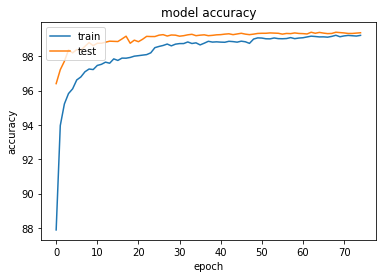

In [10]:
plt.plot(train_accuracys)
plt.plot(test_accuracys)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()